##  Linear Regression (Spark)  
**Mục tiêu**  
1. Xây mô hình hồi quy tuyến tính trên dữ liệu chất lượng không khí 2020-2021 (đã EDA & làm sạch).  
2. Chia dữ liệu làm 10 cụm sử dụng K-folds
3. Đánh giá bằng R2 Score và RMSE, MEA, MSE.
4. Lưu model


In [ ]:
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import time
import matplotlib.pyplot as plt
import numpy as np

# Khởi tạo sparksession
spark = SparkSession.builder.appName("LinearRegressionAQI").getOrCreate()

df = spark.read.csv(r"E:\BTLPTDLL-2025\datasets\processed_data_2020_2021.csv", header=True, inferSchema=True)
print("Spark đã được khởi tạo!")
print("Rows:", df.count(), "  Cols:", len(df.columns))


Spark đã được khởi tạo!
Rows: 3941   Cols: 16 [('Date', 'date'), ('Station name', 'string'), ('Wind', 'double'), ('CO', 'double'), ('Dew', 'double'), ('Humidity', 'double'), ('NO2', 'double'), ('O3', 'double'), ('PM10', 'double'), ('PM25', 'double'), ('Pressure', 'double'), ('SO2', 'double'), ('Temperature', 'double'), ('AQI index', 'double'), ('Dominent pollutant', 'string'), ('Status', 'string')]


In [2]:
# 3. Tiền xử lý dữ liệu
# Loại bỏ các dòng thiếu AQI index
df = df.filter(df["AQI index"].isNotNull())
# Đổi tên/loại cho một số cột (optional)
print("Rows:", df.count(), "  Cols:", len(df.columns))

Rows: 3941   Cols: 16


### Đặc trưng gốc sử dụng

Trước khi tiến hành xây dựng pipeline, chúng ta phân loại các feature theo 3 nhóm cơ bản dựa trên tên cột của dataset:

| Nhóm        | Cột                                                                 |
|-------------|---------------------------------------------------------------------|
| Numeric     | `Wind`, `CO`, `Dew`, `Humidity`, `NO2`, `O3`, `PM10`, `PM2.5`, `Pressure`, `SO2`, `Temperature` |
| Categorical | `Station name`, `Dominent pollutant`, `Status`                      |
| Date/Time   | `Date`                                                              |

- **AQI index** là nhãn mục tiêu (target) cho bài toán hồi quy tuyến tính.
- Các đặc trưng số (numeric) sẽ được sử dụng trực tiếp hoặc chuẩn hóa.
- Các đặc trưng phân loại (categorical) sẽ được mã hóa (encoding) trước khi đưa vào mô hình.
- Có thể trích xuất thêm đặc trưng thời gian từ cột `Date` nếu cần.


### Baseline Linear Regression

Pipeline baseline gồm:
1. **StringIndexer** cho các cột phân loại (`Station name`, `Dominent pollutant`, `Status`).
2. **VectorAssembler** gom các feature số và đã mã hóa thành vector đặc trưng.
3. **LinearRegression** dự đoán trên target `AQI index`.

Feature set sử dụng toàn bộ các đặc trưng gốc đã liệt kê ở trên (bao gồm cả numeric và categorical).


In [ ]:
feature_cols = ['Wind',  'CO', 'Dew', 'Humidity', 'NO2', 'O3', 'PM10', 'PM25', 'Pressure',
                 'SO2', 'Temperature']
target_col = 'AQI index'
#  Khởi tạo các evaluator
rmse_evaluator = RegressionEvaluator(
    labelCol=target_col, 
    predictionCol="prediction", 
    metricName="rmse"
)

mae_evaluator = RegressionEvaluator(
    labelCol=target_col, 
    predictionCol="prediction", 
    metricName="mae"
)

r2_evaluator = RegressionEvaluator(
    labelCol=target_col, 
    predictionCol="prediction", 
    metricName="r2"
)

mse_evaluator = RegressionEvaluator(
    labelCol=target_col, 
    predictionCol="prediction", 
    metricName="mse"
)
# Chuẩn bị dữ liệu cho mô hình
assembler = VectorAssembler(inputCols=feature_cols,
                            outputCol='features_raw')

scaler = StandardScaler(inputCol="features_raw",
                        outputCol="features",
                        withMean=True,
                        withStd=True)

linear_reg = LinearRegression(featuresCol="features",
                              labelCol=target_col,
                              maxIter=1000,
                              regParam=0.05,
                              elasticNetParam=0.0)
pipeline = Pipeline(stages=[assembler, scaler, linear_reg])
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_data)
predictions = model.transform(test_data)
# Đánh giá mô hình
rmse = rmse_evaluator.evaluate(predictions)
mae = mae_evaluator.evaluate(predictions)
r2 = r2_evaluator.evaluate(predictions)
mse = mse_evaluator.evaluate(predictions)
print(f"\nKẾT QUẢ: ")
print(f"-" * 40)
print(f"RMSE (Root Mean Squared Error) : {rmse:.2f}")
print(f"MAE (Mean Absolute Error)      : {mae:.2f}")
print(f"R² (R-squared)                 : {r2 * 100:.2f}%")
print(f"MSE (Mean Squared Error)       : {mse:.2f}")
print(f"-" * 40)

# Hiển thị 10 dự đoán mẫu
print(f"\nDỰ ĐOÁN:")
predictions.select(target_col, "prediction").show(10)


KẾT QUẢ: 
----------------------------------------
RMSE (Root Mean Squared Error) : 31.16
MAE (Mean Absolute Error)      : 26.07
R² (R-squared)                 : 61.31%
MSE (Mean Squared Error)       : 970.89
----------------------------------------

DỰ ĐOÁN:
+---------+------------------+
|AQI index|        prediction|
+---------+------------------+
|    165.0|133.33890283888775|
|    134.0| 92.07031557822049|
|     87.0| 68.46585111688552|
|    166.0|139.12373321682176|
|    178.0|155.44948695436636|
|    181.0|161.17522136164803|
|    169.0|141.23658116840193|
|    173.0| 142.3595391758602|
|    163.0|  136.667487361066|
|    112.0| 88.33982978115614|
+---------+------------------+
only showing top 10 rows


In [ ]:
# Chuyển đổi nhãn air_quality thành chỉ số số (label)
# indexer = StringIndexer(inputCols=["Station name", "Dominent pollutant", "Status"],
#                         outputCols=["StationIndex", "DominentPollutantIndex", "StatusIndex"],
#                         handleInvalid="keep")
# , 'StationIndex', 'DominentPollutantIndex', 'StatusIndex'
feature_cols = ['Wind',  'CO', 'Dew', 'Humidity', 'NO2', 'O3', 'PM10', 'PM25', 'Pressure',
                 'SO2', 'Temperature']
target_col = "AQI index"
assembler = VectorAssembler(inputCols=feature_cols,
                            outputCol='features_raw')
scaler = StandardScaler(inputCol="features_raw",
                        outputCol="features",
                        withMean=True,
                        withStd=True)

linear_reg = LinearRegression(featuresCol="features",
                              labelCol=target_col,
                              maxIter=1000,
                              regParam=0.01,
                              elasticNetParam=0.0)
# Thêm cột id để chia K-fold
data_with_id = df.withColumn("id", F.monotonically_increasing_id())

# chia dữ liệu thành K phần
k = 10
folds = data_with_id.randomSplit([1.0 / k] * k, seed=48)

print(f"\n=== Chia dữ liệu thành {k} folds ===")
for i, fold in enumerate(folds):
    print(f"Fold {i+1}: {fold. count()} samples")


pipline = Pipeline(stages=[assembler, scaler, linear_reg])


print("Khởi tạo mô hình thành công!")



=== Chia dữ liệu thành 10 folds ===
Fold 1: 358 samples
Fold 2: 399 samples
Fold 3: 386 samples
Fold 4: 414 samples
Fold 5: 416 samples
Fold 6: 388 samples
Fold 7: 403 samples
Fold 8: 400 samples
Fold 9: 382 samples
Fold 10: 395 samples
Khởi tạo mô hình thành công!


In [5]:
# lưu trữ kết quả
results = dict()
traing_times = []

# Huan luyện và đánh giá mô hình trên từng fold
for i in range(k):
    print(f"\nFold: {i+1}/{k} ")
    # Tạo tập huấn luyện và tập kiểm tra
    test_fold = folds[i]
    train_fold = data_with_id.subtract(test_fold)
    
    # Huấn luyện mô hình
    start_time = time.time()
    model = pipline.fit(train_fold)
    end_time = time.time()
    
    training_time = end_time - start_time
    traing_times.append(training_time)
    print(f"Thời gian huấn luyện: {training_time:.2f} giây")
    
    # Dự đoán trên tập kiểm tra
    predictions = model.transform(test_fold)
    
    # Đánh giá mô hình
    rmse = rmse_evaluator.evaluate(predictions)
    mae = mae_evaluator.evaluate(predictions)
    r2 = r2_evaluator.evaluate(predictions)
    mse = mse_evaluator.evaluate(predictions)
    
 # In kết quả từng fold
    print(f"\nKẾT QUẢ: ")
    print(f"-" * 40)
    print(f"RMSE (Root Mean Squared Error) : {rmse:.2f}")
    print(f"MAE (Mean Absolute Error)      : {mae:.2f}")
    print(f"R² (R-squared)                 : {r2 * 100:.2f}%")
    print(f"MSE (Mean Squared Error)       : {mse:.2f}")
    print(f"Training Time                  : {training_time:.3f} giây")
    print(f"-" * 40)
    
        # Hiển thị một số dự đoán mẫu
    print(f"\nDỰ ĐOÁN:")
    predictions. select(target_col, "prediction").show(10)
    # Lưu kết quả
    results["rmse"] = rmse
    results["mae"] = mae
    results["r2"] = r2 * 100  # chuyển đổi sang phần trăm
    results["mse"] = mse
    results["training_time"] = training_time
# Lưu model 
model.write().overwrite().save("./linear_regression_aqi")


Fold: 1/10 
Thời gian huấn luyện: 3.45 giây

KẾT QUẢ: 
----------------------------------------
RMSE (Root Mean Squared Error) : 29.62
MAE (Mean Absolute Error)      : 25.58
R² (R-squared)                 : 65.25%
MSE (Mean Squared Error)       : 877.06
Training Time                  : 3.450 giây
----------------------------------------

DỰ ĐOÁN:
+---------+------------------+
|AQI index|        prediction|
+---------+------------------+
|     72.0|60.141892136248735|
|    170.0|137.42460644508384|
|    181.0|160.94160976002277|
|    110.0|  78.0310062043836|
|    169.0|132.27974261409298|
|    232.0| 259.1439311889044|
|    170.0|144.46748610292084|
|    188.0|198.09899167241565|
|    153.0|104.11172370471607|
|    149.0| 92.39212622593435|
+---------+------------------+
only showing top 10 rows

Fold: 2/10 
Thời gian huấn luyện: 2.15 giây

KẾT QUẢ: 
----------------------------------------
RMSE (Root Mean Squared Error) : 31.97
MAE (Mean Absolute Error)      : 26.92
R² (R-squared)  

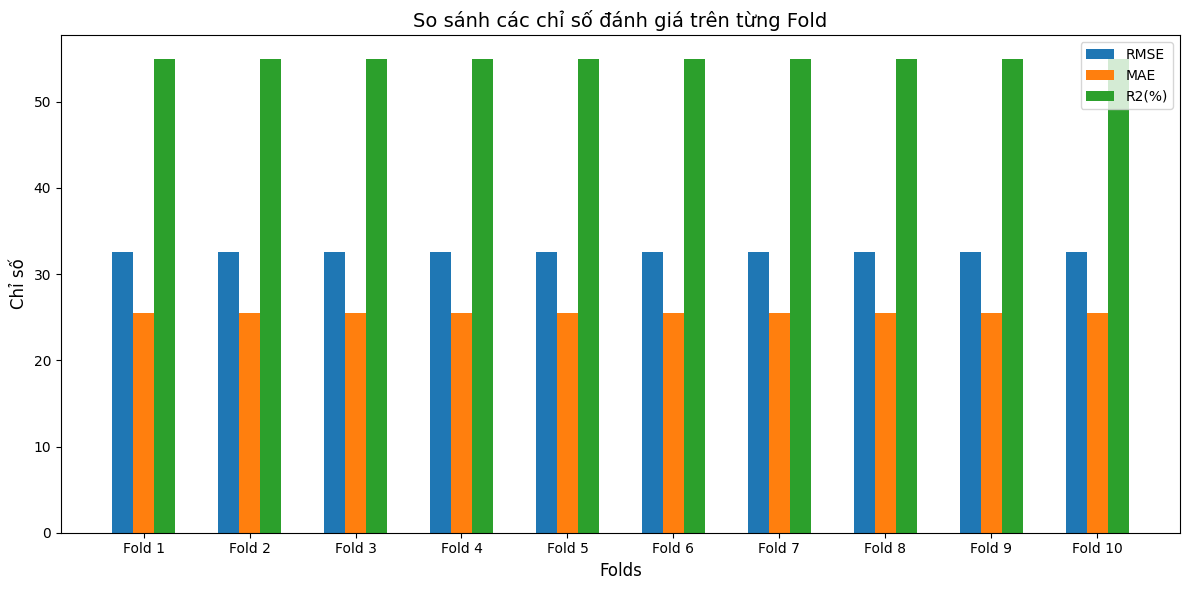

In [9]:
folds = list(range(1, k + 1))

metris = {
    "rmse": results["rmse"],
    "mae": results["mae"],
    "r2(%)": results["r2"],
}
num_metrics = len(metris)
bar_width = 0.2
x = np.arange(len(folds))

plt.figure(figsize=(12, 6))
for i, (metric_name, metric_values) in enumerate(metris.items()):
    plt.bar(x + i * bar_width, [metric_values] * k, width=bar_width, label=metric_name.upper())
plt.xlabel("Folds", fontsize=12)
plt.ylabel("Chỉ số", fontsize=12)
plt.title("So sánh các chỉ số đánh giá trên từng Fold", fontsize=14)
plt.xticks(x + bar_width * (num_metrics - 1) / 2, [f'Fold {i}' for i in folds])
plt.legend()
plt.tight_layout()
plt.savefig("linear_regression_aqi_metrics_comparison.png")
plt.show()

Vì bộ dữ liệu ít có sự tương tác giữa các cột thuộc tính, nên bọn em không thể dùng các biến tương tác để làm đầu vào để cải thiện mô hình.
